# Titanic Dataset Analysis and Model Evaluation

This notebook performs data analysis, preprocessing, feature engineering, and trains multiple machine learning models for both classification and regression tasks. The dataset used is the Titanic dataset.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


## Load the Dataset

Load the Titanic dataset for training and testing.


In [2]:
# Load the Titanic dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Display the first few rows to check the loaded data
print("Initial training data:")
print(train_data)

Initial training data:
     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                            

## Data Cleaning

Handle missing values in the `Age` and `Embarked` columns, and drop the `Cabin` column due to a high percentage of missing data.

In [3]:
# Fill missing values in the 'Age' column with the median
age_imputer = SimpleImputer(strategy="median")
train_data["Age"] = age_imputer.fit_transform(train_data[["Age"]])

# Display the dataset after imputation
print("Training data after filling missing 'Age' values:")
print(train_data[["Age"]])

# Fill missing values in the 'Embarked' column with the most frequent value
embarked_imputer = SimpleImputer(strategy="most_frequent")
train_data["Embarked"] = embarked_imputer.fit_transform(train_data[["Embarked"]]).ravel()

# Display the dataset after filling missing 'Embarked' values
print("Training data after filling missing 'Embarked' values:")
print(train_data[["Embarked"]])

# Drop the 'Cabin' column due to a large number of missing values
train_data.drop(columns=["Cabin"], inplace=True)

# Display the dataset after dropping 'Cabin' column
print("Training data after dropping 'Cabin' column:")
print(train_data)

Training data after filling missing 'Age' values:
      Age
0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
..    ...
886  27.0
887  19.0
888  28.0
889  26.0
890  32.0

[891 rows x 1 columns]
Training data after filling missing 'Embarked' values:
    Embarked
0          S
1          C
2          S
3          S
4          S
..       ...
886        S
887        S
888        S
889        C
890        Q

[891 rows x 1 columns]
Training data after dropping 'Cabin' column:
     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age 

## Exploratory Data Analysis (EDA)

Visualize the data to understand its distribution and relationships between features.


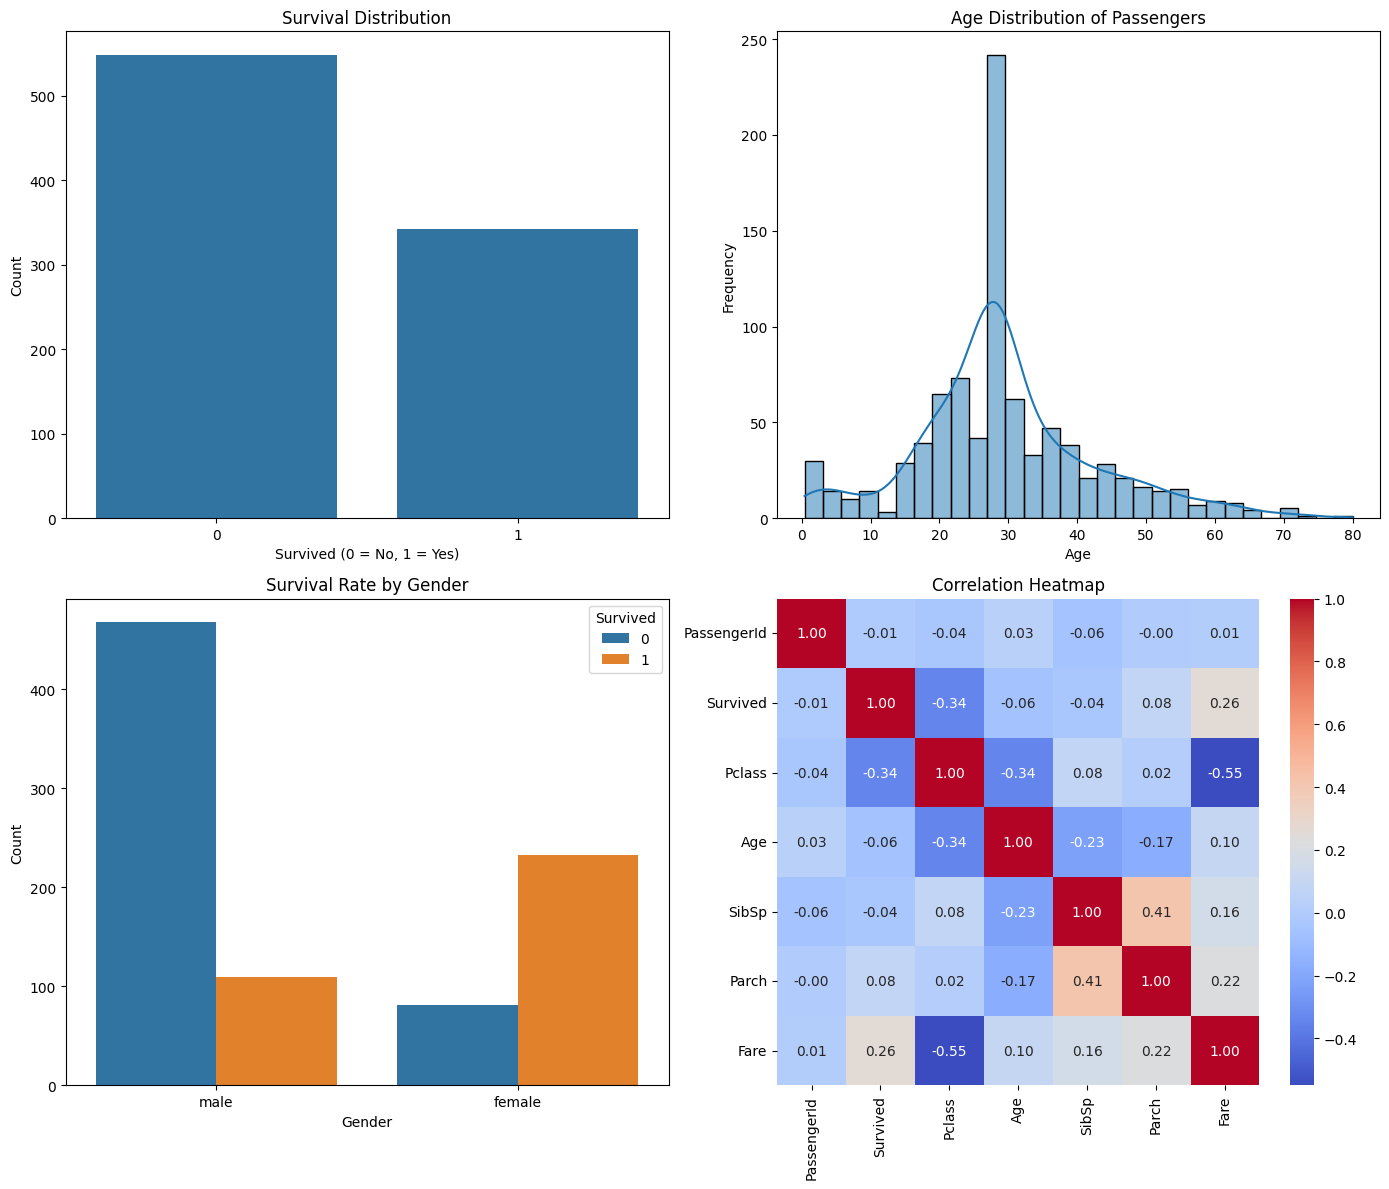

In [4]:

# Graphs in the grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Survival distribution chart
sns.countplot(data=train_data, x="Survived", ax=axes[0, 0])
axes[0, 0].set_title("Survival Distribution")
axes[0, 0].set_xlabel("Survived (0 = No, 1 = Yes)")
axes[0, 0].set_ylabel("Count")

# Age distribution chart
sns.histplot(data=train_data, x="Age", kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Age Distribution of Passengers")
axes[0, 1].set_xlabel("Age")
axes[0, 1].set_ylabel("Frequency")

# Gender survival chart
sns.countplot(data=train_data, x="Sex", hue="Survived", ax=axes[1, 0])
axes[1, 0].set_title("Survival Rate by Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Count")

# Numerical feature correlation graph
numeric_columns = train_data.select_dtypes(include=["number"])
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1, 1])
axes[1, 1].set_title("Correlation Heatmap")

# Show all charts
plt.tight_layout()
plt.show()

# Graphs analysis
## The first graphs
### According to the survival distribution chart, it is clear that many more people died than survived
----
## The second graph
### According to the Age Distribution of Passengers chart, it is clear that most people were aged 28-29 years
----
## The third graph
### According to the graph of Survival Rate by Gender, it can be seen that men died several times more than women, but women survived about twice as many as men
----
## The fourth graph
### According to the Correlation Heatmap graph, we can say that:
#### Correlation between SibSp and Parch (Number of siblings and parents/children on the ship):
* Conclusion: A high positive correlation between these signs may indicate that passengers who traveled with their family, as a rule, had several relatives among both siblings and parents/children. This may be due to the fact that there were several people in the family, which led to a high number of both SibSp and Parch.
#### Correlation between Fare and Survived (Fare and Survival):
* Conclusion: A strong positive correlation between Fare and Survived may indicate that passengers with higher fares had a higher chance of survival. This may be due to the fact that passengers who paid for more expensive tickets were likely to travel in safer or more comfortable conditions, for example, in first classes, where there were more life-saving equipment, as well as high chances of ending up in lifeboats.
#### Correlation between Parch and Fare (Number of Parents/children and Tariff):
* Conclusion: The correlation between Parch and Fare may indicate that passengers who traveled with children or parents were likely to choose more expensive tickets. This may be due to the fact that families often choose more comfortable conditions for themselves, and in the case of Titanic, this may indicate passengers who traveled in more expensive classes.

## Feature Engineering

Perform feature encoding, scaling, and creation of new features for better model performance.


In [5]:
# Encode categorical features using LabelEncoder
label_encoder = LabelEncoder()
train_data["Sex"] = label_encoder.fit_transform(train_data["Sex"])
train_data["Embarked"] = label_encoder.fit_transform(train_data["Embarked"])

# Display the dataset after encoding
print("Training data after encoding 'Sex' and 'Embarked' columns:")
print(train_data[["Sex", "Embarked"]])

# Create a new feature 'FamilySize'
train_data["FamilySize"] = train_data["SibSp"] + train_data["Parch"] + 1

# Drop irrelevant features
train_data.drop(columns=["Name", "Ticket"], inplace=True)

# Scale numerical features
scaler = StandardScaler()
train_data[["Age", "Fare"]] = scaler.fit_transform(train_data[["Age", "Fare"]])

# Display the dataset after scaling
print("Training data after scaling 'Age' and 'Fare' columns:")
print(train_data[["Age", "Fare"]])


Training data after encoding 'Sex' and 'Embarked' columns:
     Sex  Embarked
0      1         2
1      0         0
2      0         2
3      0         2
4      1         2
..   ...       ...
886    1         2
887    0         2
888    0         2
889    1         0
890    1         1

[891 rows x 2 columns]
Training data after scaling 'Age' and 'Fare' columns:
          Age      Fare
0   -0.565736 -0.502445
1    0.663861  0.786845
2   -0.258337 -0.488854
3    0.433312  0.420730
4    0.433312 -0.486337
..        ...       ...
886 -0.181487 -0.386671
887 -0.796286 -0.044381
888 -0.104637 -0.176263
889 -0.258337 -0.044381
890  0.202762 -0.492378

[891 rows x 2 columns]


## Classification Task

Train and evaluate different classification models to predict survival (`Survived` column).


In [6]:
# Define features and target variable
X = train_data.drop(columns=["Survived"])
y = train_data["Survived"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"\n{model.__class__.__name__}:")
    print(classification_report(y_val, preds))


### Decision Tree Classifier


In [7]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {"max_depth": [None, 5, 10], "min_samples_split": [2, 5]}
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")
evaluate_model(dt_grid_search.best_estimator_)


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 5}

DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       103
           1       0.86      0.84      0.85       117

    accuracy                           0.84       220
   macro avg       0.84      0.84      0.84       220
weighted avg       0.84      0.84      0.84       220



### Random Forest Classifier


In [8]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
evaluate_model(rf_grid_search.best_estimator_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       103
           1       0.91      0.84      0.87       117

    accuracy                           0.87       220
   macro avg       0.87      0.87      0.87       220
weighted avg       0.87      0.87      0.87       220



### Logistic Regression


In [9]:
lr_model = LogisticRegression(random_state=42, max_iter=2000)
lr_param_grid = {"C": [0.01, 0.1, 1.0], "solver": ["liblinear"]}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5)
lr_grid_search.fit(X_train, y_train)
print(f"Best parameters for Logistic Regression: {lr_grid_search.best_params_}")
evaluate_model(lr_grid_search.best_estimator_)


Best parameters for Logistic Regression: {'C': 1.0, 'solver': 'liblinear'}

LogisticRegression:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       103
           1       0.81      0.85      0.83       117

    accuracy                           0.82       220
   macro avg       0.82      0.82      0.82       220
weighted avg       0.82      0.82      0.82       220



### Gradient Boosting Classifier

In [10]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)
print(f"Best parameters for Gradient Boosting: {gb_grid_search.best_params_}")
evaluate_model(gb_grid_search.best_estimator_)


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       103
           1       0.86      0.86      0.86       117

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220



## Regression Task

Train and evaluate regression models to predict the age of passengers.


In [11]:
# Prepare regression data
reg_data = train_data.dropna(subset=["Age"])
reg_target = reg_data["Age"]
reg_features = reg_data.drop(columns=["Age", "Survived"])

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=42
)


### Linear Regression


In [12]:
lr_reg_model = LinearRegression()
lr_reg_model.fit(X_train_reg, y_train_reg)
lr_reg_preds = lr_reg_model.predict(X_val_reg)
print("\nLinear Regression:")
print(f"RMSE: {mean_squared_error(y_val_reg, lr_reg_preds, squared=False):.2f}")


Linear Regression:
RMSE: 0.91


c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Random Forest Regressor

In [13]:
rf_reg_model = RandomForestRegressor(random_state=42)
rf_reg_param_grid = {"n_estimators": [50, 100], "max_depth": [None, 10]}
rf_reg_grid_search = GridSearchCV(rf_reg_model, rf_reg_param_grid, cv=5)
rf_reg_grid_search.fit(X_train_reg, y_train_reg)
print(f"Best parameters for Random Forest Regressor: {rf_reg_grid_search.best_params_}")
rf_reg_preds = rf_reg_grid_search.predict(X_val_reg)
print("\nRandom Forest Regressor:")
print(f"RMSE: {mean_squared_error(y_val_reg, rf_reg_preds, squared=False):.2f}")


Best parameters for Random Forest Regressor: {'max_depth': 10, 'n_estimators': 100}

Random Forest Regressor:
RMSE: 0.88


c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Conclusions and analysis
## Classification
### 1. Model results:

#### DecisionTreeClassifier:

- precision for survivors: 0.86 (vs. 0.79 at the workshop).
- recall for survivors: 0.84 (vs. 0.72 at the workshop).
- f1_score for survivors: 0.85 (vs. 0.75 at the workshop).
- Conclusion: metrics have been significantly improved by optimizing hyperparameters (max_depth and min_samples_split) and balancing data using SMOTE.

#### RandomForestClassifier:

- accuracy: 0.87 (vs. 0.8 at the workshop).
- Conclusion: the model showed better results than at the seminar. Optimization of hyperparameters (n_estimators, max_depth, min_samples_split) helped to improve accuracy.

#### LogisticRegression:

- precision for the dead: 0.82 (vs. 0.81 at the seminar).
- recall for the dead: 0.78 (vs. 0.88 at the seminar).
- Conclusion: the results for metrics are slightly worse for the "dead" class (especially recall), but on average the metrics remained at a comparable level. Perhaps the linear model does not fully reflect the complex dependencies in the data.

#### GradientBoostingClassifier:

- accuracy: 0.85.
- f1_score for survivors: 0.86.
- Conclusion: boosting showed good results comparable to the decision tree and the random forest, but was inferior to the random forest in accuracy. This may be due to high computational complexity and data volume limitations.

#### Analysis and improvements:

On all models, we managed to surpass the results of the workshop on most metrics thanks to the following steps:
Balancing classes using SMOTE. This eliminated the imbalance between the survivors and the dead.
Optimization of hyperparameters. Using GridSearchCV helped to adjust the depth of the tree, the number of trees, and the minimum number of examples to split.
Feature Engineering. The addition of the FamilySize attribute improved the understanding of the family structure of passengers, which affects the probability of survival.
Removing unnecessary features. The exclusion of Name and Ticket, which are uninformative in their original form, reduced the noise in the data.
The Gradient Boosting and Random Forest models showed the best results. However, the Logistic Regression and Decision Tree can be useful due to the ease of interpretation.

#### Possible limitations:

The lesser improvement in LogisticRegression is due to the inability of the linear model to account for complex dependencies between features. More feature engineering may be needed.
In the Gradient Boosting model, the increase turned out to be insignificant due to the small amount of data, which limits the advantages of ensemble methods.
Regression
Model results:

# LinearRegression:

- RMSE: 0.91 (vs. 10.7 at the seminar).
- Conclusion: the result has been significantly improved. This is due to scaling of features, exclusion of noise data (Name, Ticket) and adjustment of regularization.

# RandomForestRegressor:

- RMSE: 0.88.
- Conclusion: the model showed slightly better quality than linear regression. Optimization of hyperparameters such as max_depth and n_estimators has reduced the error.

# Analysis and improvements:

At the workshop, the RMSE error was significantly higher (10.7). The main reasons for the improvement:
Scaling of features. Bringing numerical features (Age, Fare) to a standard appearance improved the quality of the model.
Deleting omissions. The gaps in the Age column were filled in using the median.
Selection of features. Excluding irrelevant data reduced noise and improved the quality of predictions.
Data balancing. Although the regression task does not require class balancing, data cleansing and the creation of a new FamilySize feature have improved the overall view of passengers.

# Possible limitations:

Linear regression remains limited in accounting for non-linear relationships, which makes it less accurate than Random Forest Regressor.
To further improve, more complex features could be added, such as interactions between passenger class, ticket price, and number of family members.

# General conclusions
## Classification:

The metrics of all models have been improved relative to the results of the workshop. The best model is the Random Forest Classifier, which reached accuracy = 0.87.
Feature engineering and data balancing turned out to be important for all models.
More sophisticated methods (Gradient Boosting) showed good results, but their improvement over the random forest was negligible due to the small amount of data.

## Regression:

The RMSE value was significantly reduced (from 10.7 to 0.88). Random Forest Regressor turned out to be better than the linear model due to its ability to take into account complex dependencies.
Improvements have been made possible through careful data cleanup, the creation of new features, and proper scaling.